In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import FinanceDataReader as fdr
import plotly.express as px

In [115]:
def get_returns_df(df, N=1, log=False):
    if log:
        return np.log(df/df.shift(N)).iloc[N-1:].fillna(0)
    else:
        return df.pct_change(N, fill_method=None).iloc[N-1:].fillna(0)
    
def get_cum_returns_df(return_df, log=False):
    if log:
        return np.exp(return_df.cumsum())
    else:
        return (1 + return_df).cumprod()

In [116]:
def get_annualized_returns_series(log_return_df, num_day_in_year=250):
    return (log_return_df.mean() * num_day_in_year).round(2)

def get_annualized_std_series(log_return_df, num_day_in_year=250 ):
    return (log_return_df.std()*(num_day_in_year ** 0.5)).round(2)

In [117]:
def get_cagr_series(cum_rtn_df, num_day_in_year = 250):
    cagr_series = cum_rtn_df.iloc[-1]**(num_day_in_year/(len(cum_rtn_df))) -1
    return cagr_series

In [154]:
def get_sharpe_ratio(log_rtn_df, yearly_rfr = 0.025):
    excess_rtns = log_rtn_df.mean()*252 - yearly_rfr
    return excess_rtns / (log_rtn_df.std() * np.sqrt(252))

In [160]:
def get_drawdown_infos(cum_returns_df):
    cummax_df = cum_returns_df.cummax()
    dd_df = cum_returns_df / cummax_df -1
    
    mdd_series = dd_df.min()
    
    max_point_df = dd_df[dd_df == 0]
    
    first_df = max_point_df.index[:-1]
    second_df = max_point_df.index[1:]
    
    period = first_df - second_df
    
    longest_dd_period = period.min().days
    
    ldd_st = first_df[period.argmin()]
    ldd_ed = second_df[period.argmin()]
    
    return mdd_series, longest_dd_period, ldd_st, ldd_ed

### 이동평균선 매매전략

In [121]:
df = fdr.DataReader('005930','2010-01-02','2020-10-30')
# df = df.Close
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516
2010-01-05,16520,16580,16300,16440,559219,0.016069
2010-01-06,16580,16820,16520,16820,459755,0.023114
2010-01-07,16820,16820,16260,16260,443237,-0.033294
2010-01-08,16400,16420,16120,16420,295798,0.009840
...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322
2020-10-27,60300,60300,59500,59800,17260416,-0.009934
2020-10-28,59400,59400,58800,59000,14428882,-0.013378


In [122]:
df['sma'] = df.Close.rolling(5).mean()
df['lma'] = df.Close.rolling(20).mean()
df.head()

,Open,High,Low,Close,Volume,Change,sma,lma
Date,,,,,,,,
2010-01-04,16060,16180,16000,16180,239271,0.012516,NaN,NaN
2010-01-05,16520,16580,16300,16440,559219,0.016069,NaN,NaN
2010-01-06,16580,16820,16520,16820,459755,0.023114,NaN,NaN
2010-01-07,16820,16820,16260,16260,443237,-0.033294,NaN,NaN
2010-01-08,16400,16420,16120,16420,295798,0.009840,16424.0,NaN


In [123]:
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

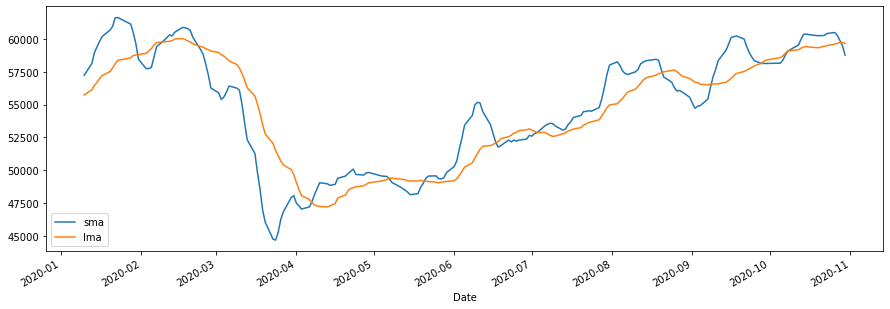

In [124]:
# df[['Close','sma','lma']].iloc[-100:].plot(figsize=(15,5))
df[['sma','lma']].iloc[-200:].plot(figsize=(15,5))

In [125]:
df['position'] = np.where(df['sma'] >= df['lma'], 1, 0)   # 1이 매수표시

In [126]:
df

,Open,High,Low,Close,Volume,Change,sma,lma,position
Date,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0
...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1


<AxesSubplot:xlabel='Date'>

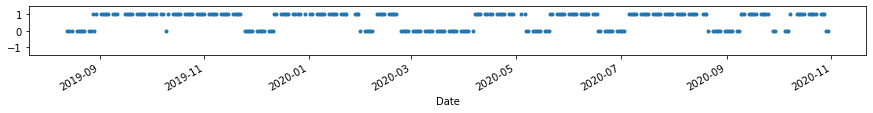

In [127]:
df['position'][-300:].plot(marker='.', linestyle='none', figsize=(15,1), ylim=[-1.5, 1.5])

In [128]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

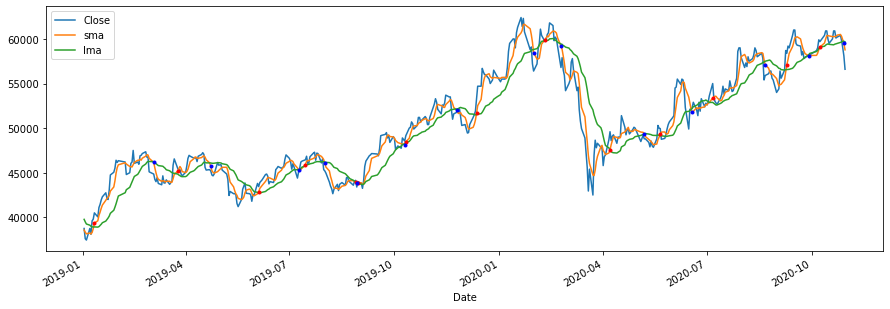

In [129]:
# df[['Close']].loc['2020-01-01':].plot(figsize=(15,5), color='black')
df[['Close','sma','lma']].loc['2019-01-01':].plot(figsize=(15,5))
df.loc[long_index, 'sma'].loc['2019-01-01':].plot(marker='o', color='red', linestyle='none', markersize=3)
df.loc[exit_index, 'sma'].loc['2019-01-01':].plot(marker='o', color='blue', linestyle='none', markersize=3)

In [130]:
df.loc[:,'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn
Date,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288
...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468


In [131]:
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

In [132]:
df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
df

,Open,High,Low,Close,Volume,Change,sma,lma,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,,,
2010-01-29,16000,16019,15600,15680,457285,-0.029703,16196.0,16402.0,0,0.000000,0.000000,1.000000
2010-02-01,15679,15700,15300,15540,501042,-0.008929,15936.0,16370.0,0,-0.008969,-0.000000,1.000000
2010-02-02,15800,15800,15400,15440,393803,-0.006435,15764.0,16320.0,0,-0.006456,-0.000000,1.000000
2010-02-03,15640,15700,15360,15540,330235,0.006477,15672.0,16256.0,0,0.006456,0.000000,1.000000
2010-02-04,15500,15660,15440,15520,239799,-0.001287,15544.0,16219.0,0,-0.001288,-0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,60400,61100,60100,60400,13268226,0.003322,60500.0,59610.0,1,0.003317,0.003317,1.352149
2020-10-27,60300,60300,59500,59800,17260416,-0.009934,60280.0,59670.0,1,-0.009983,-0.009983,1.338717
2020-10-28,59400,59400,58800,59000,14428882,-0.013378,59900.0,59730.0,1,-0.013468,-0.013468,1.320808


In [168]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [169]:
print('cagr : ', cagr)
print('sharp_ratio : ', sharp_ratio)
print('Max_drawdown : ', mdd_series)
print('Longest_dd_period : ', ldd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr :  -0.012801575103867036
sharp_ratio :  -0.11121261924501334
Max_drawdown :  -0.18589743589743601
Longest_dd_period :  -13
Longest_dd_st_date : 2018-05-15 00:00:00
Longest_dd_ed_date : 2018-05-28 00:00:00


<AxesSubplot:xlabel='Date'>

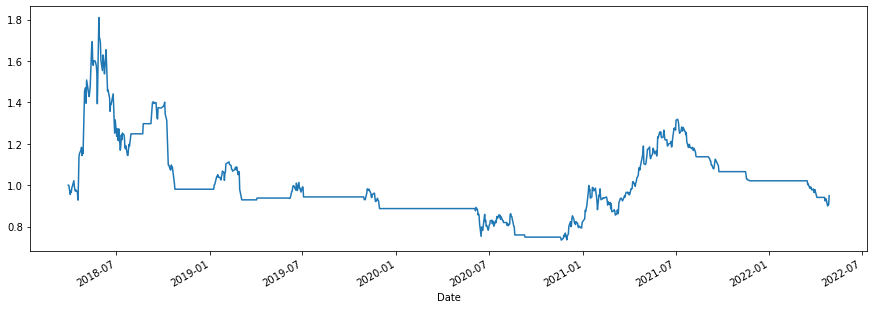

In [171]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

# Momentum : 상승한 종목에 재투자

In [136]:
df = fdr.DataReader('005930','2018-01-02','2020-04-29')

In [137]:
momentum_window=20*3

In [138]:
get_returns_df(df['Close'], N=momentum_window)

Date
2018-03-29    0.000000
2018-03-30   -0.035280
2018-04-02   -0.059667
2018-04-03   -0.057948
2018-04-04   -0.099770
                ...   
2020-04-23   -0.156514
2020-04-24   -0.137238
2020-04-27   -0.116135
2020-04-28   -0.124126
2020-04-29   -0.151104
Name: Close, Length: 513, dtype: float64

In [141]:
position = np.sign(get_returns_df(df['Close'], N=momentum_window))   # 3개월동안 올랐으면 1, 안올랐으면 -1
position.head()

Date
2018-03-29    0.0
2018-03-30   -1.0
2018-04-02   -1.0
2018-04-03   -1.0
2018-04-04   -1.0
Name: Close, dtype: float64

In [142]:
position.value_counts()

 1.0    276
-1.0    233
 0.0      4
Name: Close, dtype: int64

In [143]:
position[position == -1] = 0

In [144]:
position.value_counts()

1.0    276
0.0    237
Name: Close, dtype: int64

<AxesSubplot:xlabel='Date'>

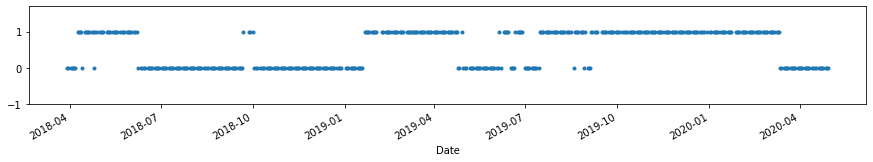

In [146]:
position.plot(marker='.', linestyle='none', figsize=(15,2), ylim=[-1.01, 1.7])

In [147]:
df.loc[:, 'position'] = position

In [148]:
df.dropna(inplace=True)

In [149]:
long_index = df[(df['position'] - df['position'].shift(1)) == 1].index
exit_index = df[(df['position'] - df['position'].shift(1)) == -1].index

<AxesSubplot:xlabel='Date'>

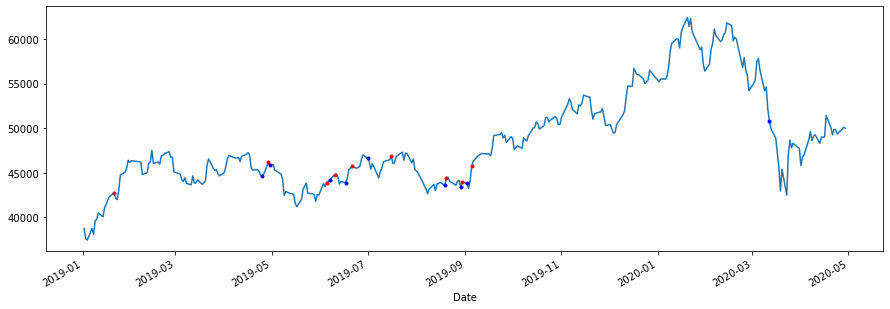

In [150]:
ax = df.loc[:, 'Close'].loc['2019-01-01':].plot(figsize=(15,5))

df.loc[long_index, 'Close'].loc['2019-01-01':].plot(ax=ax, marker='o', color='red', linestyle='none', markersize=3)
df.loc[exit_index, 'Close'].loc['2019-01-01':].plot(ax=ax, marker='o', color='blue', linestyle='none', markersize=3)

In [151]:
df.loc[:,'rtn'] = get_returns_df(df['Close'], N=1, log=True)
df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)  # 투자수익률

df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)  # 누적 투자 수익률

In [152]:
df

,Open,High,Low,Close,Volume,Change,position,rtn,str_rtn,cum_str_rtn
Date,,,,,,,,,,
2018-03-29,48700,49560,48320,49040,201340,0.006982,0.0,0.000000,0.0,1.000000
2018-03-30,49080,49900,49080,49220,155542,0.003670,0.0,0.003664,0.0,1.000000
2018-04-02,49000,49220,48500,48540,142313,-0.013816,0.0,-0.013912,-0.0,1.000000
2018-04-03,47880,48140,47280,48120,255365,-0.008653,0.0,-0.008690,-0.0,1.000000
2018-04-04,48160,48260,46920,46920,247684,-0.024938,0.0,-0.025254,-0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
2020-04-23,50200,50300,49500,49850,18754442,0.000000,0.0,0.000000,0.0,0.976559
2020-04-24,49650,49750,49000,49350,15618347,-0.010030,0.0,-0.010081,-0.0,0.976559
2020-04-27,49350,50000,49100,49850,14049471,0.010132,0.0,0.010081,0.0,0.976559


In [162]:
cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
mdd_series, longest_dd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])

In [164]:
print('cagr : ', cagr)
print('sharp_ratio : ', sharp_ratio)
print('Max_drawdown : ', mdd_series)
print('Longest_dd_period : ', longest_dd_period)
print('Longest_dd_st_date :', ldd_st)
print('Longest_dd_ed_date :', ldd_ed)

cagr :  -0.01149304459923095
sharp_ratio :  -0.20182715537169668
Max_drawdown :  -0.18589743589743601
Longest_dd_period :  -607
Longest_dd_st_date : 2018-04-19 00:00:00
Longest_dd_ed_date : 2019-12-17 00:00:00


<AxesSubplot:xlabel='Date'>

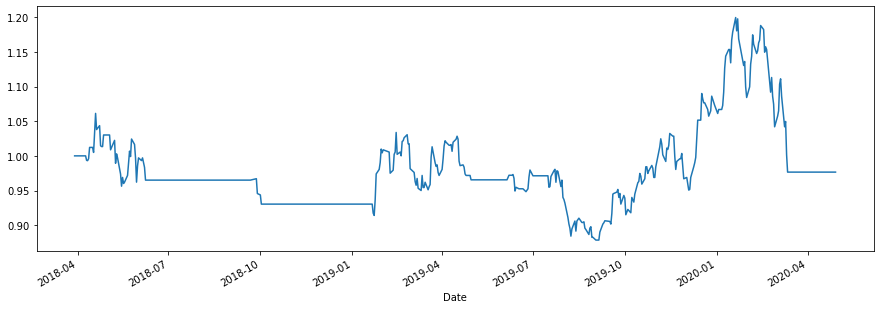

In [165]:
df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))

In [166]:
def momentum(df, mw):
    
    momentum_window=mw
    
    position = np.sign(get_returns_df(df['Close'], N=momentum_window))
    position[position == -1] = 0
    
    df.loc[:, 'position'] = position
    df.dropna(inplace=True)
    
    df.loc[:, 'rtn'] = get_returns_df(df['Close'], N=1, log=True)
    df.loc[:, 'str_rtn'] = (df['position'].shift(1) * df['rtn']).fillna(0)

    df.loc[:, 'cum_str_rtn'] = get_cum_returns_df(df['str_rtn'], log=True)
    
    cagr = get_cagr_series(df['cum_str_rtn'], num_day_in_year = 250)
    sharp_ratio = get_sharpe_ratio(df['str_rtn'], yearly_rfr = 0.025)
    mdd, ldd_period, ldd_st, ldd_ed = get_drawdown_infos(df['cum_str_rtn'])
    
    print('cagr :', cagr)
    print('sharp_ratio :', sharp_ratio)
    print('Max_drawdown :', mdd_series)
    print('Longest_dd_period :', ldd_period)
    print('Longest_dd_st_date :', ldd_st)
    print('Longest_dd_ed_date :', ldd_ed)
    
    df.loc[:, 'cum_str_rtn'].plot(figsize=(15,5))
    
    

cagr : -0.012801575103867036
sharp_ratio : -0.11121261924501334
Max_drawdown : -0.18589743589743601
Longest_dd_period : -13
Longest_dd_st_date : 2018-05-15 00:00:00
Longest_dd_ed_date : 2018-05-28 00:00:00


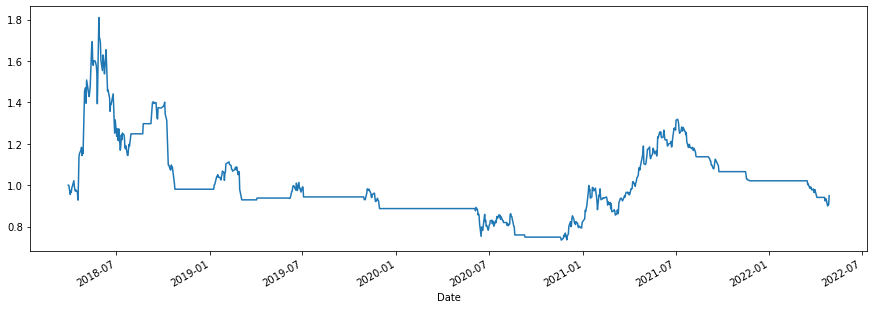

In [167]:
df = fdr.DataReader('000720','2018-01-02','2022-04-29')
mw = 60

momentum(df, mw)